In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.7 MB/s 
     |████████████████████████████████| 120 kB 86.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.2 MB/s 


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 8.1 MB/s 
     |████████████████████████████████| 115 kB 72.6 MB/s 
     |████████████████████████████████| 212 kB 61.8 MB/s 
     |████████████████████████████████| 127 kB 71.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 9.1 MB/s 


In [5]:
!nvidia-smi

Fri Sep  9 06:11:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os
import gc
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from sklearn.metrics import log_loss,f1_score

from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')
OUTPUT_DIR = os.path.join(DIR,'output')
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,'submission')
#OUTPUT_MODEL_DIR = os.path.join(OUTPUT_DIR,'model')
OUTPUT_MODEL_DIR = DIR + '/output/model/EXP08/'
if not os.path.exists(OUTPUT_MODEL_DIR):
    os.makedirs(OUTPUT_MODEL_DIR)

In [8]:
class CFG:
    num_workers=2
    path=OUTPUT_MODEL_DIR
    config_path=path+'config.pth'
    tokenizer=path+'tokenizer/'
    model="microsoft/deberta-v3-large"
    batch_size=32
    dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True

In [9]:
# Loss Func
def criterion(outputs, labels):
    return nn.BCEWithLogitsLoss()(outputs, labels)

def get_score(labels, outputs):
    best_score = 0
    best_thresh = 0.5
    y_pred = outputs
    y_true = labels
    for thresh in np.arange(0.2, 0.801, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        print("F1 score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(y_true, (y_pred>best_thresh).astype(int))))
    return best_thresh

def get_logger(filename=OUTPUT_MODEL_DIR+'train'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [10]:
oof_df = pd.read_pickle(OUTPUT_MODEL_DIR+'oof_df.pkl')
labels = oof_df['label'].values
preds = oof_df['pred'].values
best_thresh=get_score(labels,preds)
#LOGGER.info(f'CV Score: {score:<.4f}')

F1 score at threshold 0.2 is 0.8140518668383299
F1 score at threshold 0.21 is 0.813712807244502
F1 score at threshold 0.22 is 0.8144922164566345
F1 score at threshold 0.23 is 0.815131517799052
F1 score at threshold 0.24 is 0.8157060249953367
F1 score at threshold 0.25 is 0.8156048273926466
F1 score at threshold 0.26 is 0.8153571763822398
F1 score at threshold 0.27 is 0.8153657847660295
F1 score at threshold 0.28 is 0.8159486016628874
F1 score at threshold 0.29 is 0.8157271435338701
F1 score at threshold 0.3 is 0.8159619952494062
F1 score at threshold 0.31 is 0.8161204268292682
F1 score at threshold 0.32 is 0.8159327538446844
F1 score at threshold 0.33 is 0.8162483234336079
F1 score at threshold 0.34 is 0.8169853011816697
F1 score at threshold 0.35 is 0.8171483622350674
F1 score at threshold 0.36 is 0.8174265842349305
F1 score at threshold 0.37 is 0.8171688789845946
F1 score at threshold 0.38 is 0.8167946350471377
F1 score at threshold 0.39 is 0.8164815897136178
F1 score at threshold 0.

In [11]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"
        
        if hasattr(embeddings_path, attr_name): 
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [12]:
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'),header=None)
sub.columns = ['id','state']

In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)

def remove_html(text):
    html=re.compile(r"<[^>]*?>")
    return html.sub('',text)

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_URL(text)
        text = remove_html(text)
        #アルファベット以外をスペースに置き換え
        #clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #改行削除
        text = text.replace("\n","")
        clean_texts.append(text)
    return clean_texts


from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text


test['html_content'] = cleaning(test['html_content'])
test['html_content'] = test['html_content'].apply(lambda x : resolve_encodings_and_normalize(x))
test['html_content'] = test['html_content'].fillna('missing')
test['inputs'] = test.goal + ' ; ' + test.duration.astype(str) + ' [SEP] ' + test.country + ' [SEP] ' + test.category1 + ' ; ' + test.category2 + ' [SEP] ' + test.html_content
display(test.head())

,id,goal,country,duration,category1,category2,html_content,inputs
0,test_00000,5001-6000,FR,30,dance,performances,"Bonjour ,Je m'appelle Morgane Hilgers. Je suis...",5001-6000 ; 30 [SEP] FR [SEP] dance ; performa...
1,test_00001,6001-7000,GB,23,publishing,children's books,The projectThe hidden world of microorganisms ...,6001-7000 ; 23 [SEP] GB [SEP] publishing ; chi...
2,test_00002,6001-7000,GB,30,theater,plays,"COW is a rural tragicomedy with songs, written...",6001-7000 ; 30 [SEP] GB [SEP] theater ; plays ...
3,test_00003,1001-2000,CA,14,art,digital art,I've been creating landscape images using crea...,1001-2000 ; 14 [SEP] CA [SEP] art ; digital ar...
4,test_00004,1-1000,US,30,music,hip-hop,Ive been making hip hop music for ten years no...,1-1000 ; 30 [SEP] US [SEP] music ; hip-hop [SE...


In [14]:
tokenizer = AutoTokenizer.from_pretrained(CFG.tokenizer)
CFG.tokenizer = tokenizer
SEP = tokenizer.sep_token

In [15]:
class Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = CFG.max_len
        self.text = df['inputs'].values
        self.tokenizer = CFG.tokenizer
        #self.targets = df['label'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length = self.max_len
        )
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            #'target': self.targets[index]
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
            
        return samples

In [16]:
class Collate:
    def __init__(self, tokenizer, isTrain=True):
        self.tokenizer = tokenizer
        self.isTrain = isTrain
        # self.args = args

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        if self.isTrain:
            output["target"] = [sample["target"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s + (batch_max - len(s)) * [0] for s in output["attention_mask"]]
        else:
            output["input_ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["input_ids"]]
            output["attention_mask"] = [(batch_max - len(s)) * [0] + s for s in output["attention_mask"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)
        if self.isTrain:
            output["target"] = torch.tensor(output["target"], dtype=torch.long)

        return output
    
collate_fn = Collate(CFG.tokenizer, isTrain=False)

In [17]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9) #
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings

In [18]:
class CustomModel(nn.Module):
    def __init__(self, model_name):
        super(CustomModel, self).__init__()
        # Header (fast or normal)
        
        self.config = self.config = torch.load(CFG.config_path)

        self.model = AutoModel.from_config(self.config)

        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.mean_pooler = MeanPooling()
        self.max_pooler = MaxPooling()
        self.output = nn.Linear(self.config.hidden_size*2, CFG.target_size)
        self._init_weights(self.output)
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size*2)
        
        # Gradient_checkpointing
        if CFG.gradient_checkpointing:
            (self.model).gradient_checkpointing_enable()
        
        # Freezing
        if CFG.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            CFG.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())
        
        

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)


    def forward(self, ids, mask):

        transformer_out = self.model(input_ids=ids, 
                         attention_mask=mask,
                         output_hidden_states=False)
        output = transformer_out.last_hidden_state
        output = self.dropout(output)
      
        mean_pool = self.mean_pooler(output, mask)
        max_pool = self.max_pooler(output,mask)

        concat = torch.cat([mean_pool,max_pool],dim=1)

        sequence_output = self.layer_norm1(concat)

        logits = self.output(sequence_output)
     
        return logits

In [19]:
def inference_one_epoch(model, dataloader, device):
    model.eval()
    pred = []
    model.to(device)
    for step, data in enumerate(dataloader):
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        with torch.no_grad():
            outputs = model(ids, mask)
        pred.append(outputs.sigmoid().to('cpu').numpy())
    pred = np.concatenate(pred)
    return pred

In [20]:
testdataset = Dataset(test, CFG.tokenizer, CFG.max_len)

test_loader = DataLoader(testdataset, 
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         collate_fn = collate_fn,
                         num_workers = CFG.num_workers,
                         pin_memory = True,
                         drop_last = False,
                         )

predictions = []

for fold in CFG.trn_fold:
    print("="*10,f" fold{fold} start ","="*10)
    model = CustomModel(CFG.model)
    config_path=CFG.config_path
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location = torch.device('cpu'))
    model.load_state_dict(state['model'])

    prediction = inference_one_epoch(model, test_loader, device)
    predictions.append(prediction)
    del model, state, prediction
    gc.collect()
    torch.cuda.empty_cache()
    print("="*10,f" fold{fold} end ","="*10)

==========  fold0 start  ==========
==========  fold0 end  ==========
==========  fold1 start  ==========
==========  fold1 end  ==========
==========  fold2 start  ==========
==========  fold2 end  ==========
==========  fold3 start  ==========
==========  fold3 end  ==========


In [21]:
submit = sub.copy()
submit.columns = ["id","label"]


submit_predictions = np.mean(predictions, axis=0)
submit['label'] = submit_predictions
submit['state1'] = (submit_predictions>best_thresh).astype(int)
submit['state2'] = (submit_predictions>0.5).astype(int)

submit[["id","state1"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"exp008_bestthresh_submission8155.csv"),index=False,header=False)
submit[["id","state2"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"exp008_.5_submission8155.csv"),index=False,header=False)
display(submit)

,id,label,state1,state2
0,test_00000,0.795662,1,1
1,test_00001,0.999727,1,1
2,test_00002,0.990699,1,1
3,test_00003,0.044067,0,0
4,test_00004,0.082392,0,0
...,...,...,...,...
9795,test_09795,0.564228,1,1
9796,test_09796,0.998482,1,1
9797,test_09797,0.466194,1,0
9798,test_09798,0.885502,1,1


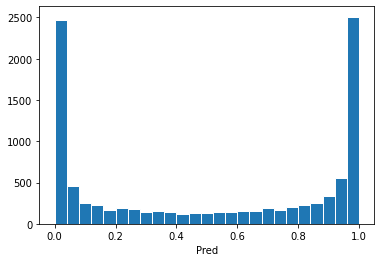

In [22]:
plt.hist(submit.label,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [23]:
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup= submit[submit["id"].isin(dup_test_ids)]  

In [24]:
T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup,how='left',on='id')
T

,train id,true label,id,label,state1,state2
0,train_01463,1,test_01704,0.999002,1,1
1,train_06891,1,test_03707,0.999215,1,1
2,train_08302,1,test_04353,0.979728,1,1
3,train_04506,1,test_04453,0.999707,1,1
4,train_09470,0,test_04645,0.214706,0,0
5,train_02156,1,test_06909,0.888079,1,1
6,train_00365,0,test_08232,0.242003,0,0
